## MNIST Handwritten digits classifier

In [1]:
# Import the goodies
%matplotlib inline

import numpy as np
import time
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, accuracy_score
import seaborn as sns

In [2]:
# Load the data (Automatically downloads from AWS, so no file manpulation needed)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# Reshape the data
X = x_train.reshape(60000, 28, 28, 1)
y = y_train.reshape(60000, 1)

# Process the data (To float)
X = X / 255.0

# Onehot encode y_train
enc = OneHotEncoder().fit(y)
y = enc.transform(y).toarray()

In [4]:
# Format the test dataset (However, no processing is done on the set)
X_ = x_test.reshape(10000, 28, 28, 1)
y_ = enc.transform(y_test.reshape((10000,1))).toarray()

X_ = X_ / 255.0

To find the most ambigious images in the test dataset, we must first build a classifier that gives us the probability of which digit it is. This is done using a [Convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) written in Keras/Tensorflow

Necessary requirements are in `requirements.txt`

In [5]:
# Build the network
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))  # Filter the data
model.add(layers.MaxPooling2D((2,2)))                                            # Make the view larger; find bigger patterns
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())                                                      # Dimension reduce
model.add(layers.Dropout(0.5))                                                   # Get rid of conspiracies
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", verbose=1),  # Stop early if training is only going ok
    tf.keras.callbacks.ModelCheckpoint("net1.h5", save_best_only=True, monitor="val_loss"),                      # To save the best weights
    tf.keras.callbacks.ProgbarLogger(),
]

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               4

2021-09-09 22:05:29.930651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-09 22:05:29.938509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-09 22:05:29.939078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-09 22:05:29.940109: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
# Fit the network
params = {
    'epochs': 100,
    'batch_size': 256,
    'verbose': 0,
    'validation_split': 0.2,
    'callbacks': callbacks
}

tick = time.time()
history = model.fit(X, y,  **params)
print(f'{(time.time()-tick).__round__(2)} seconds to train')    
    
model.save('net1.h5')

2021-09-09 22:05:30.490956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-09 22:05:31.203869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-09-09 22:05:32.053359: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
47.89 seconds to train


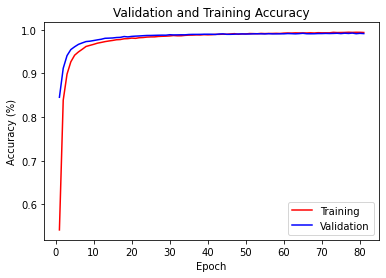

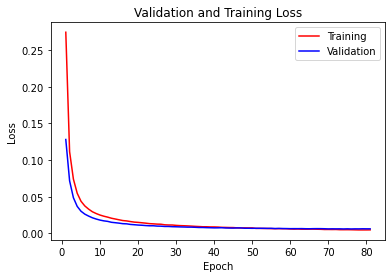

In [7]:
# Plot the training history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r-', label='Training')
plt.plot(epochs, val_acc, 'b-', label='Validation')
plt.title('Validation and Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'r-', label='Training')
plt.plot(epochs, val_loss, 'b-', label='Validation')
plt.title('Validation and Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [8]:
# How well did the model work?
train_preds = model.predict(X)
print("Training data")
print("Loss", log_loss(y, train_preds))
print("Acc", accuracy_score(y_train, train_preds.argmax(axis=1)))

preds = model.predict(X_)
print("\nTest data:")
print("Loss", log_loss(y_, preds))
print("Acc", accuracy_score(y_test, preds.argmax(axis=1)))

Training data
Loss 0.01656877341912087
Acc 0.99605

Test data:
Loss 0.028536008968894425
Acc 0.9926


The model ended up with 99.2% accuracy on the test set showing that it fit to the data very well.
It can then provide us with valuable insight towards the test dataset of unusual digits in the dataset

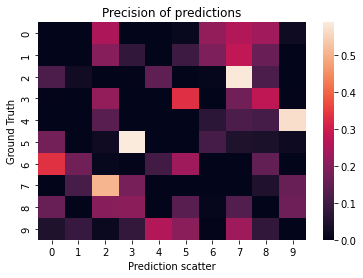

In [9]:
# Find what the model's predictions actually were
summary = np.zeros((10,10))

for p, truth in zip(preds.copy(), y_test):
    p[truth] = 0  # Remove the correct result
    summary[truth] += p

row_sums = summary.sum(axis=1)
summary = summary / row_sums[:, np.newaxis]  

# Add a seaborn plot to show the scatter of the 1-10 classes
ax = plt.axes()
sns.heatmap(summary, ax=ax)
ax.set_title(f'Precision of predictions')
plt.ylabel("Ground Truth")
plt.xlabel("Prediction scatter")
plt.show()

This plot shows the scatter present in the predictions of the model when not considering the correct answer. Lighter squares show where the model commonly confused different digits, however this gives only general trends

In [10]:
# Create a useful table of results to analyse
arr = np.vstack((np.arange(0,10000), y_test, preds.argmax(axis=1), np.max(preds, axis=1))).T
# Arr by columns: Index, Truth, Guess, Confidence

# Find the 10 most worst classified datapoints (by its own estimation: sort by 4th column)
arr = arr[arr[:,3].argsort()]
arr

array([[4.76100000e+03, 9.00000000e+00, 8.00000000e+00, 4.25442070e-01],
       [1.03900000e+03, 7.00000000e+00, 7.00000000e+00, 4.80446577e-01],
       [4.24800000e+03, 2.00000000e+00, 2.00000000e+00, 4.84062403e-01],
       ...,
       [4.10500000e+03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.13000000e+03, 7.00000000e+00, 7.00000000e+00, 1.00000000e+00],
       [9.99900000e+03, 6.00000000e+00, 6.00000000e+00, 1.00000000e+00]])

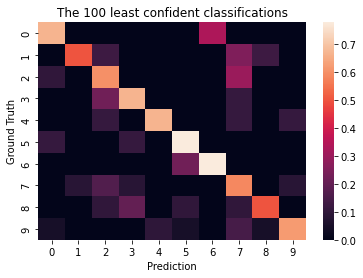

In [11]:
# Show worst digits classified (Least confident)
n = 100
heat = np.zeros((10,10))

for i, truth, guess, con in arr[:n]:
    heat[int(truth), int(guess)] += 1

row_sums = heat.sum(axis=1)
heat = heat / row_sums[:, np.newaxis] 

ax = plt.axes()
sns.heatmap(heat, ax=ax)
ax.set_title(f'The {n} least confident classifications')
plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.show()

This shows the digits that the model was unsure about (Lower confidence spread over multiple classes). However, the diagonal is still the most common prediction, showing the model is accurate.

Least confident digits (Right and wrong)


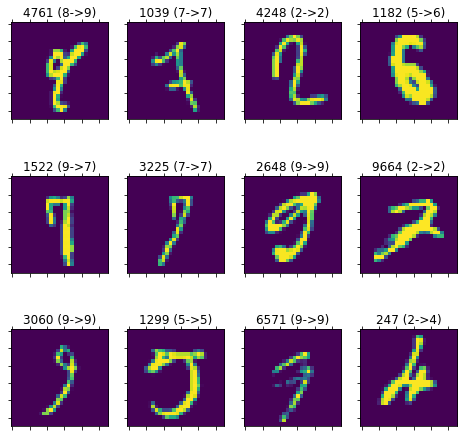

In [12]:
# Show 12 of these digits
cols = 4
rows = 3
to_plot = arr[:, 0][:rows*cols].astype('int')
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[to_plot[cnt]])
        axs[i, j].set_title(f'{to_plot[cnt]} ({int(arr[j+i*cols, 2])}->{int(arr[j+i*cols, 1])})')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1
print("Least confident digits (Right and wrong)")
plt.show()

Legend: `ID (GUESS -> TRUTH)`

These digits are very vague and the model struggles to get them correct as a result. (As it correctly gave a low confidence)

Most confident incorrect digits


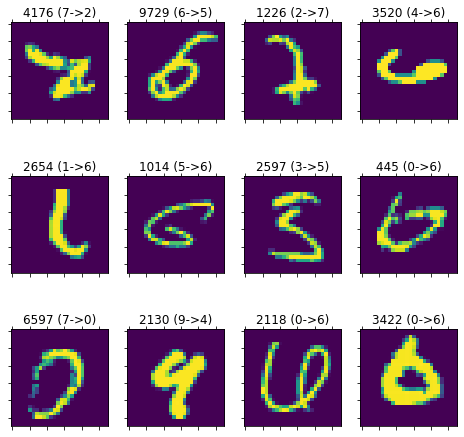

In [13]:
# Looking at all the digits that the classifier got wrong, which ones was it most confident about?
wrong = arr[arr[:,1] != arr[:,2]]
wrong = wrong[wrong[:,3].argsort()[::-1]]  # Set into descending order (Most confident)
cols = 4
rows = 3

wrong_indx = wrong[:, 0].astype('int')
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

#fig.tight_layout()
cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[wrong_indx[cnt]])
        axs[i, j].set_title(f'{wrong_indx[cnt]} ({int(wrong[j+i*cols, 2])}->{int(wrong[j+i*cols, 1])})')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1
print("Most confident incorrect digits")
plt.show()

These are the digits that the model was most confident about, but was wrong. Most of them are very ambigious to me too. Overall, I think the model has done very well to find the most ambiguous digits in the dataset.

Examples
- 4176 (Looks like a scribble)
- 9729 (I would have guessed a 6 too)
- 3520 (Looks like neither a 4 nor 6)
- 2654 (Appears to be a 1 not a 6)

In [14]:
# Save the 10 most ambigious images to disk (Filename is the index of the image in the test dataset)
img_folder = "imgs/"
for i in range(10):
    plt.imsave(img_folder + str(wrong_indx[i]) + ".jpg", x_test[wrong_indx[i]])